In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [3]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

In [4]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [6]:
train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

In [8]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))


Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [13]:
# Create dictionary of target classes
label_dict = {
 0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
}


Text(0.5, 1.0, '(Label: 7)')

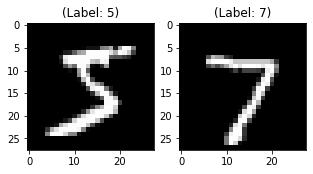

In [14]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")


In [15]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [16]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [17]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [18]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [19]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [24]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)


In [25]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))


In [26]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded


In [27]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())


In [28]:
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856 

In [ ]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))


Epoch 1/50
375/375 [==============================] - 67s 177ms/step - loss: 0.1130 - val_loss: 0.1123
Epoch 2/50
375/375 [==============================] - 66s 177ms/step - loss: 0.1119 - val_loss: 0.1123
Epoch 3/50
375/375 [==============================] - 67s 179ms/step - loss: 0.1119 - val_loss: 0.1123
Epoch 4/50
375/375 [==============================] - 67s 178ms/step - loss: 0.1119 - val_loss: 0.1123
Epoch 5/50
375/375 [==============================] - 67s 179ms/step - loss: 0.1119 - val_loss: 0.1123
Epoch 6/50
375/375 [==============================] - 69s 183ms/step - loss: 0.1119 - val_loss: 0.1123
Epoch 7/50
375/375 [==============================] - 69s 183ms/step - loss: 0.1119 - val_loss: 0.1123
Epoch 8/50
375/375 [==============================] - 69s 184ms/step - loss: 0.1119 - val_loss: 0.1123
Epoch 9/50
375/375 [==============================] - 68s 181ms/step - loss: 0.1119 - val_loss: 0.1123
Epoch 10/50
375/375 [==============================] - 69s 183ms/step - l